## Dependencies 

In [5]:
import os 
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import cv2
import random
from scipy import ndimage
from tqdm  import tqdm
import albumentations as A 

## Extract and Label data

In [16]:
def get_labels() -> list[dict]:
    furniture_path = './Furniture_Data'
    labels =  []
    for root, _, files in os.walk(furniture_path):
        for file in files:
            if file.endswith('.jpg'):
                
                path = os.path.join(root, file)
                dirs = path.split(os.path.sep)

                furniture = dirs[2][:-1] #Remove trailing `s` 
                style = dirs[3].lower() #lowercase

                label = {
                    'path': path,
                    'furniture': furniture,
                    'style': style
                }

                labels.append(label)

    return pd.DataFrame(labels)

df = get_labels()

In [7]:
df.head()

,path,furniture,style
0,./Furniture_Data/tables/Eclectic/4029eclectic-...,table,eclectic
1,./Furniture_Data/tables/Eclectic/3879eclectic-...,table,eclectic
2,./Furniture_Data/tables/Eclectic/4107eclectic-...,table,eclectic
3,./Furniture_Data/tables/Eclectic/3785eclectic-...,table,eclectic
4,./Furniture_Data/tables/Eclectic/3950eclectic-...,table,eclectic


## EDA 

The dataset sample isn't distributed evenly across all furniture

furniture
lamp       32401
chair      22053
table      19330
dresser     7870
bed         6578
sofa        4080
Name: count, dtype: int64

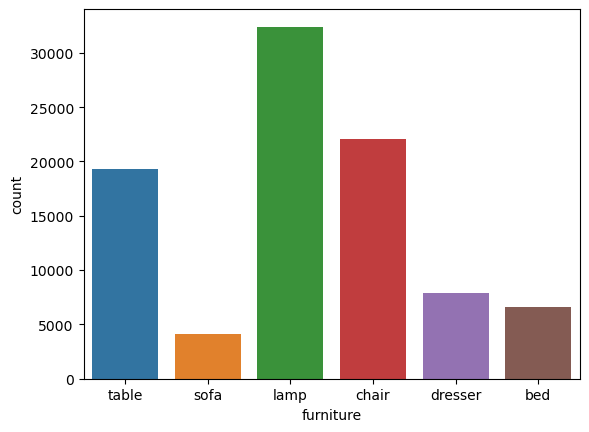

In [8]:
sns.countplot(data=df, x="furniture")

df['furniture'].value_counts()

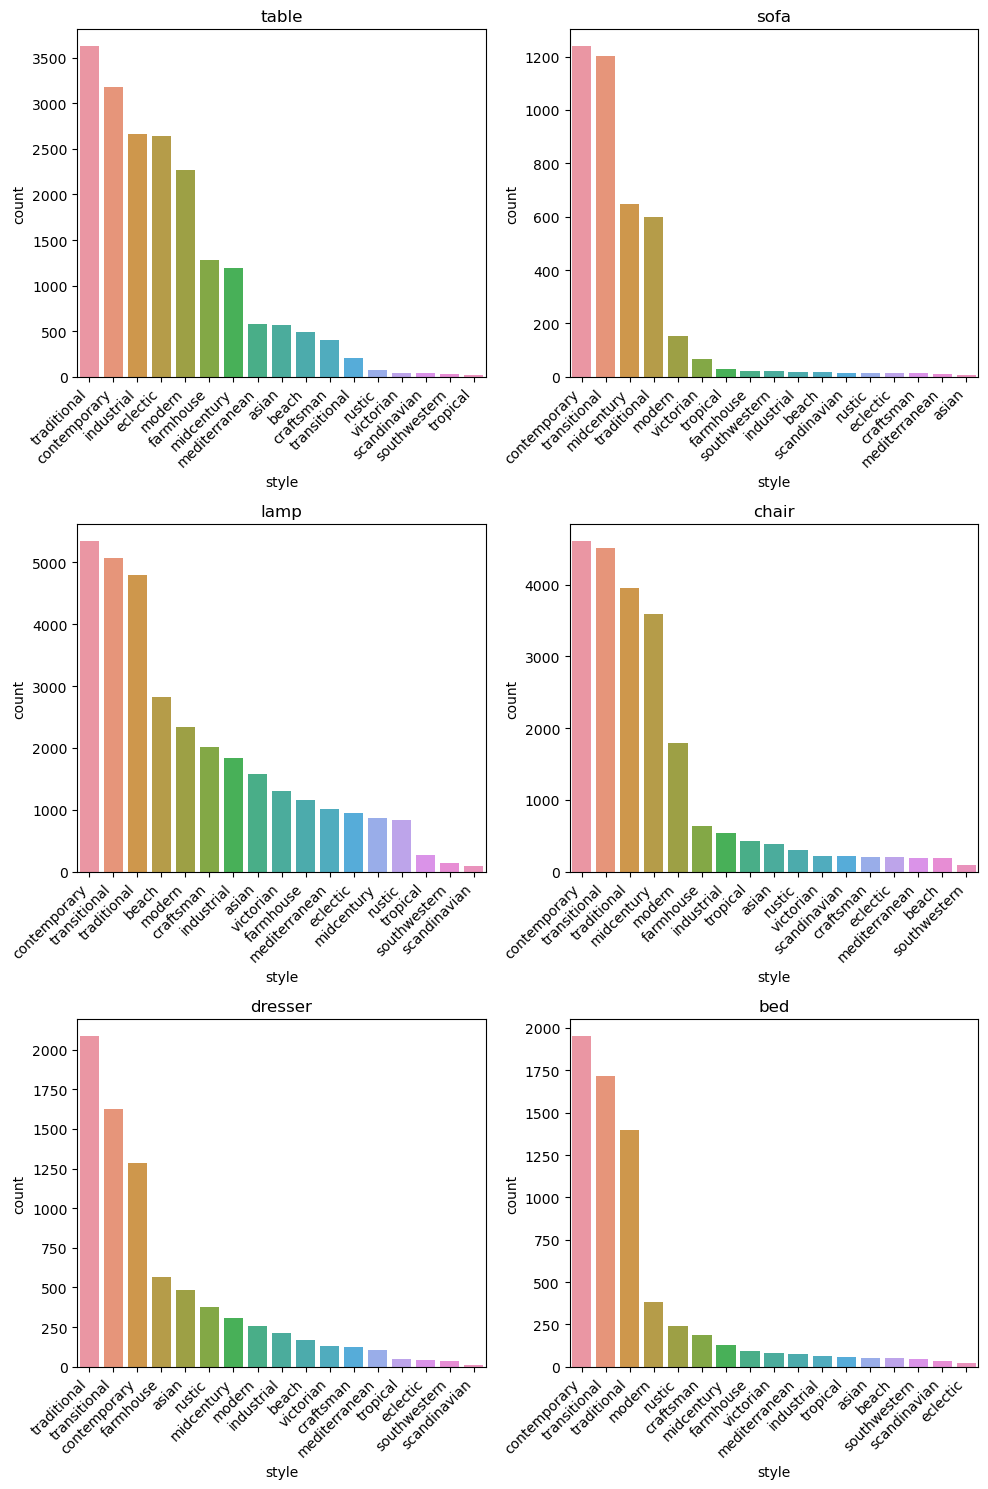

In [9]:
# Get unique furniture types
furniture_types = df['furniture'].unique()

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15), sharex=False)

# Plot each furniture type
for i, furniture_type in enumerate(furniture_types):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    data = df[df['furniture'] == furniture_type]
    sns.countplot(x='style', data=data, order=data['style'].value_counts().index, ax=ax)
    ax.set_title(furniture_type)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Show x-axis tick labels for each subplot
    ax.tick_params(axis='x', which='both', bottom=True)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

## Data Augmentation

Try to apply following data augmentation techniques 
- Flip
- Rotate
- Histogram Equalization

In [10]:
# Function for histogram equalization
def hist_equal(img):
    img_to_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    img_to_yuv[:, :, 0] = cv2.equalizeHist(img_to_yuv[:, :, 0])
    hist_equalization_result = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
    return hist_equalization_result

# Function for image zooming
def zoom_image(image, scale, center):
    
    height, width = image.shape[:2]
    new_height = int(height * scale)
    new_width = int(width * scale)

    zoomed_image = cv2.resize(image, (new_width, new_height))
    x = int(center[0] - width / 2)
    y = int(center[1] - width / 2)
    roi = zoomed_image[y : y + height, x : x + width]

    return roi

# # Function for image augmentation
# def image_augmentation(image):
#     flip_h = cv2.flip(image, 0) # Flip image horizontally

#     # Get image dimensions
#     height, width = flip_h.shape[:2]

#     # Define the zoom factor (e.g., zooming in by a factor of 1.5)
#     zoom_factor = 1.5

#     # Calculate the new dimensions after zooming
#     new_height = int(height * zoom_factor)
#     new_width = int(width * zoom_factor)

#     zoomed_image = cv2.resize(image, (new_width, new_height))
#     histogram = hist_equal(image)
#     adjusted = cv2.convertScaleAbs(histogram, alpha = 1.0, beta = 5) # Adjust image's contrast and brightness

#     return adjusted


# Function for image augmentation
def augment_image(image):
    transform = A.Compose([
    A.CLAHE(),
    A.RandomRotate90(),
    A.Transpose(),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.50, rotate_limit=45, p=.75),
    A.Blur(blur_limit=3),
    A.OpticalDistortion(),
    A.GridDistortion(),
    A.HueSaturationValue(),
])
    augmented_image = transform(image=image)['image']
    return augmented_image

**Resampling Problem Brainstorming**
- Flowers: Only have 1 layer of category. Can easily resample by just calculating the difference between each category with the category max amount
   - Technique: Transform the curr scanned image until the current number of category matches the maximum amount
- Furniture: Have 2 layers of categories
  - Naive resampling: Can evenly distribute across furnitures, however styles distribution can be uneven 
  - More cater resampling techniques (Proposed)
    0. Copy curr image folders to `Transformed-Furnitures`
    1. Get the amount of the style of the furniture with maximum amount. Assign to `maximum_amount`
    2. (Optional) Remove that style of the furniture if's smaller than <threshold> (suggest 5% compared to max amount)
    3. Loop thru each image of the category and apply the transformation.
      3a. Increment the `current_amount` by 1
      3b. Saved the new image to corresponding category in `Transformed Furnitures`
    5. Break if `current_amount` doesn't match `maximum_amount`
    6. Continue until end of the loop. If the `current_amount` still doesn't match the `maximum_amount`, then repeat step 3,4 and 5.

### Copy raw images dir to transformed images dir

In [11]:
raw_furniture_path = './Furniture_Data'
transformed_furniture_path = './Transfomed_Furniture_Data'

In [12]:
def copy_images_dir():
    # Terminal commands to remove the 'transformed-images' folder if it exists
    if not os.path.exists(transformed_furniture_path):        
        # Terminal command to copy images to the 'transformed-images' folder
        copy_command = f"cp -r {raw_furniture_path} {transformed_furniture_path}"
        os.system(copy_command)
        print("Copying completed successfully.")
        copy_images_dir()
    else:
        print("Folder already exist")

copy_images_dir()

Folder already exist


### Calculate Furniture Style's maximum amount

In [13]:
max_amount = df.groupby(['furniture', 'style']).size().max()
max_amount


5343

### Get combinations of furniture and style unique values 


In [14]:
category_combinations = df[['furniture', 'style']].drop_duplicates().to_records(index=False)
category_combinations[:5]

rec.array([('table', 'eclectic'), ('table', 'midcentury'),
           ('table', 'craftsman'), ('table', 'victorian'),
           ('table', 'transitional')],
          dtype=[('furniture', 'O'), ('style', 'O')])

### Transform

In [17]:
def transform(df: pd.DataFrame) -> pd.DataFrame:
    # Removed old transformed images before executing new ones
    clear_transformed_images()
    
    df_transform = None
    for furniture, style in tqdm(category_combinations):
        print(furniture, style)
        df_category = df[(df['furniture'] == furniture) & (df['style'] == style)]

        # Resize  first
        df_resized =  resize_image(df_category)
        
        df_transform = df_resized if df_transform is None else pd.concat([df_transform, df_resized], ignore_index=True)
        
        # Random pick an image in transformed image, then perform aumgnetation
        df_transform = advanced_transform(df_transform)

    
    return df_transform

def clear_transformed_images():
    # Clear images with pattern "resized" or "augmented"
    removed_augmented_command = "find . -type f -name '*-augmented*.jpg' -exec rm {} +"
    removed_resized_command = "find . -type f -name '*-resized*.jpg' -exec rm {} +"
    os.system(removed_augmented_command)
    os.system(removed_resized_command)
    print("Removed all transformed images with suffix -resized and -augmented")

def resize_image(df_category: pd.DataFrame) -> int:
    """
    Args:
    - df_category(pd.Dataframe)
    Return:
    - pd.Dataframe: New dataframe with initial images and resized images
    """
    # df_resized = df_category.copy(deep=True)
    resized_data = []
    
    for _, record in df_category.iterrows():
        # Read Image
        img_arr = cv2.imread(record['path'])
        
        # Resize
        resized_img_arr = cv2.resize(img_arr, (150, 150))
        
        # Generate a name: {current_name}-resized
        file_path, _ = os.path.splitext(record['path'])
        file_path = file_path.replace(raw_furniture_path, transformed_furniture_path)
        
        resized_path = f"{file_path}-resized.jpg"
        
        # Write output  and get path
        # print(f'Write resized image to disk {resized_path}')
        cv2.imwrite(resized_path, resized_img_arr)
        
        # Append new record to list
        resized_data.append((
            resized_path,
            record['furniture'],
            record['style']
        ))
    
    
    df_resized = pd.DataFrame(resized_data, columns=df_category.columns)
    return pd.concat([df_category, df_resized], ignore_index=True)

def advanced_transform(df_transform):
    current_amount = len(df_transform)
    augmented_data = []
    
    while current_amount < max_amount:
        # Pick random img file
        random_df_index = random.choice(df_transform.index.to_list())
        random_df_record = df_transform.iloc[random_df_index]
        
        random_img_file_path = random_df_record['path'] 
        
        #  Augment the img 
        random_img_arr = cv2.imread(random_img_file_path)
        augmented_img_arr = augment_image(random_img_arr)


        # Gen file path
        file_path, _ = os.path.splitext(random_img_file_path)
        augmented_img_file_path = f"{file_path}-augmented-{current_amount}.jpg"

        # Write augmented image to disk
        # print(f'Write augmeted image to disk {augmented_img_file_path}')
        cv2.imwrite(augmented_img_file_path, augmented_img_arr)
        
        # Store new data
        augmented_data.append((
            augmented_img_file_path,
            random_df_record['furniture'],
            random_df_record['style']
        ))
        
        current_amount += 1 

    
    df_augmented = pd.DataFrame(augmented_data, columns=df_transform.columns)
    return pd.concat([df_transform, df_augmented], ignore_index=True)
        
        



df_transformed = transform(df)

Removed all transformed images with suffix -resized and -augmented


  0%|                                                                                                | 0/102 [00:00<?, ?it/s]

table eclectic


  1%|▊                                                                                       | 1/102 [00:20<35:09, 20.89s/it]

table midcentury


  2%|█▋                                                                                      | 2/102 [00:23<16:36,  9.97s/it]

table craftsman


  4%|███▍                                                                                    | 4/102 [00:24<05:49,  3.57s/it]

table victorian
table transitional


  5%|████▎                                                                                   | 5/102 [00:24<03:59,  2.47s/it]

table mediterranean


  6%|█████▏                                                                                  | 6/102 [00:26<03:20,  2.09s/it]

table traditional


  7%|██████                                                                                  | 7/102 [00:34<06:25,  4.05s/it]

table industrial


  8%|██████▉                                                                                 | 8/102 [00:39<07:00,  4.47s/it]

table farmhouse


 11%|█████████▍                                                                             | 11/102 [00:42<03:10,  2.09s/it]

table tropical
table southwestern
table beach


 12%|██████████▏                                                                            | 12/102 [00:43<02:45,  1.84s/it]

table modern


 13%|███████████                                                                            | 13/102 [00:47<03:40,  2.48s/it]

table contemporary


 15%|████████████▊                                                                          | 15/102 [00:54<03:42,  2.56s/it]

table rustic
table scandinavian
table asian


 17%|██████████████▌                                                                        | 17/102 [00:55<02:25,  1.71s/it]

sofa eclectic
sofa midcentury


 21%|█████████████████▉                                                                     | 21/102 [00:57<01:12,  1.12it/s]

sofa craftsman
sofa victorian
sofa transitional


 22%|██████████████████▊                                                                    | 22/102 [00:59<01:41,  1.26s/it]

sofa mediterranean
sofa traditional


 25%|██████████████████████▏                                                                | 26/102 [01:01<00:54,  1.38it/s]

sofa industrial
sofa farmhouse
sofa tropical
sofa southwestern


 27%|███████████████████████▉                                                               | 28/102 [01:01<00:37,  1.97it/s]

sofa beach
sofa modern


 29%|█████████████████████████▌                                                             | 30/102 [01:01<00:29,  2.46it/s]

sofa contemporary


 33%|█████████████████████████████                                                          | 34/102 [01:04<00:31,  2.14it/s]

sofa rustic
sofa scandinavian
sofa asian
lamp eclectic
lamp midcentury


 35%|██████████████████████████████▋                                                        | 36/102 [01:07<00:55,  1.19it/s]

lamp craftsman


 36%|███████████████████████████████▌                                                       | 37/102 [01:12<01:31,  1.40s/it]

lamp victorian


 37%|████████████████████████████████▍                                                      | 38/102 [01:14<01:46,  1.66s/it]

lamp transitional


 38%|█████████████████████████████████▎                                                     | 39/102 [01:24<03:41,  3.51s/it]

lamp mediterranean


 39%|██████████████████████████████████                                                     | 40/102 [01:26<03:16,  3.18s/it]

lamp traditional


 40%|██████████████████████████████████▉                                                    | 41/102 [01:36<04:56,  4.87s/it]

lamp industrial


 41%|███████████████████████████████████▊                                                   | 42/102 [01:40<04:31,  4.52s/it]

lamp farmhouse


 42%|████████████████████████████████████▋                                                  | 43/102 [01:42<03:50,  3.90s/it]

lamp tropical


 43%|█████████████████████████████████████▌                                                 | 44/102 [01:43<02:51,  2.97s/it]

lamp southwestern


 44%|██████████████████████████████████████▍                                                | 45/102 [01:43<02:05,  2.20s/it]

lamp beach


 45%|███████████████████████████████████████▏                                               | 46/102 [01:48<02:58,  3.19s/it]

lamp modern


 46%|████████████████████████████████████████                                               | 47/102 [01:53<03:13,  3.51s/it]

lamp contemporary


 47%|████████████████████████████████████████▉                                              | 48/102 [02:03<05:01,  5.58s/it]

lamp rustic


 49%|██████████████████████████████████████████▋                                            | 50/102 [02:05<02:47,  3.22s/it]

lamp scandinavian
lamp asian


 50%|███████████████████████████████████████████▌                                           | 51/102 [02:09<02:43,  3.21s/it]

chair eclectic


 51%|████████████████████████████████████████████▎                                          | 52/102 [02:09<01:59,  2.39s/it]

chair midcentury


 52%|█████████████████████████████████████████████▏                                         | 53/102 [02:16<03:08,  3.85s/it]

chair craftsman


 53%|██████████████████████████████████████████████                                         | 54/102 [02:17<02:16,  2.84s/it]

chair victorian


 54%|██████████████████████████████████████████████▉                                        | 55/102 [02:17<01:40,  2.13s/it]

chair transitional


 55%|███████████████████████████████████████████████▊                                       | 56/102 [02:28<03:29,  4.56s/it]

chair mediterranean


 56%|████████████████████████████████████████████████▌                                      | 57/102 [02:28<02:30,  3.35s/it]

chair traditional


 57%|█████████████████████████████████████████████████▍                                     | 58/102 [02:37<03:40,  5.01s/it]

chair industrial


 58%|██████████████████████████████████████████████████▎                                    | 59/102 [02:38<02:44,  3.82s/it]

chair farmhouse


 59%|███████████████████████████████████████████████████▏                                   | 60/102 [02:39<02:09,  3.07s/it]

chair tropical


 60%|████████████████████████████████████████████████████                                   | 61/102 [02:40<01:40,  2.45s/it]

chair southwestern


 61%|████████████████████████████████████████████████████▉                                  | 62/102 [02:41<01:11,  1.78s/it]

chair beach


 62%|█████████████████████████████████████████████████████▋                                 | 63/102 [02:41<00:53,  1.37s/it]

chair modern


 63%|██████████████████████████████████████████████████████▌                                | 64/102 [02:45<01:17,  2.04s/it]

chair contemporary


 64%|███████████████████████████████████████████████████████▍                               | 65/102 [02:54<02:38,  4.27s/it]

chair rustic


 65%|████████████████████████████████████████████████████████▎                              | 66/102 [02:55<01:55,  3.20s/it]

chair scandinavian


 66%|█████████████████████████████████████████████████████████▏                             | 67/102 [02:55<01:23,  2.40s/it]

chair asian


 68%|██████████████████████████████████████████████████████████▊                            | 69/102 [02:56<00:46,  1.42s/it]

dresser eclectic
dresser midcentury


 69%|███████████████████████████████████████████████████████████▋                           | 70/102 [02:57<00:38,  1.21s/it]

dresser craftsman


 70%|████████████████████████████████████████████████████████████▌                          | 71/102 [02:57<00:29,  1.06it/s]

dresser victorian


 71%|█████████████████████████████████████████████████████████████▍                         | 72/102 [02:58<00:23,  1.30it/s]

dresser transitional


 72%|██████████████████████████████████████████████████████████████▎                        | 73/102 [03:01<00:47,  1.65s/it]

dresser mediterranean


 73%|███████████████████████████████████████████████████████████████                        | 74/102 [03:02<00:34,  1.24s/it]

dresser traditional


 74%|███████████████████████████████████████████████████████████████▉                       | 75/102 [03:07<01:04,  2.37s/it]

dresser industrial


 75%|████████████████████████████████████████████████████████████████▊                      | 76/102 [03:07<00:47,  1.82s/it]

dresser farmhouse


 76%|██████████████████████████████████████████████████████████████████▌                    | 78/102 [03:09<00:29,  1.22s/it]

dresser tropical
dresser southwestern


 77%|███████████████████████████████████████████████████████████████████▍                   | 79/102 [03:09<00:20,  1.12it/s]

dresser beach


 78%|████████████████████████████████████████████████████████████████████▏                  | 80/102 [03:09<00:16,  1.35it/s]

dresser modern


 79%|█████████████████████████████████████████████████████████████████████                  | 81/102 [03:10<00:14,  1.45it/s]

dresser contemporary


 80%|█████████████████████████████████████████████████████████████████████▉                 | 82/102 [03:13<00:26,  1.35s/it]

dresser rustic


 81%|██████████████████████████████████████████████████████████████████████▊                | 83/102 [03:14<00:23,  1.23s/it]

dresser scandinavian
dresser asian


 83%|████████████████████████████████████████████████████████████████████████▌              | 85/102 [03:15<00:16,  1.04it/s]

bed eclectic
bed midcentury


 85%|██████████████████████████████████████████████████████████████████████████▏            | 87/102 [03:15<00:09,  1.59it/s]

bed craftsman


 87%|███████████████████████████████████████████████████████████████████████████▉           | 89/102 [03:16<00:06,  2.12it/s]

bed victorian
bed transitional


 89%|█████████████████████████████████████████████████████████████████████████████▌         | 91/102 [03:19<00:08,  1.28it/s]

bed mediterranean
bed traditional


 91%|███████████████████████████████████████████████████████████████████████████████▎       | 93/102 [03:21<00:07,  1.15it/s]

bed industrial
bed farmhouse


 93%|█████████████████████████████████████████████████████████████████████████████████      | 95/102 [03:21<00:03,  1.99it/s]

bed tropical
bed southwestern
bed beach


 95%|██████████████████████████████████████████████████████████████████████████████████▋    | 97/102 [03:21<00:01,  3.14it/s]

bed modern


 96%|███████████████████████████████████████████████████████████████████████████████████▌   | 98/102 [03:22<00:01,  2.67it/s]

bed contemporary


 97%|████████████████████████████████████████████████████████████████████████████████████▍  | 99/102 [03:25<00:03,  1.04s/it]

bed rustic


100%|██████████████████████████████████████████████████████████████████████████████████████| 102/102 [03:25<00:00,  2.02s/it]

bed scandinavian
bed asian


### **TODO**: Investigate why uneven distribution still persisit after performing augmentation process

In [18]:
df_transformed.furniture.value_counts()

furniture
lamp       64802
chair      44106
table      38723
dresser    15740
bed        13156
sofa        8160
Name: count, dtype: int64

In [24]:
df_transformed.query("furniture == 'table'")['style'].value_counts()

style
traditional      7258
contemporary     6354
eclectic         5343
industrial       5322
modern           4544
farmhouse        2558
midcentury       2388
mediterranean    1164
asian            1146
beach             988
craftsman         818
transitional      414
rustic            142
victorian          92
scandinavian       90
southwestern       54
tropical           48
Name: count, dtype: int64

## Post-execution

Save dataset 

In [32]:
# Define the directory to save the model
def save_dataset(df: pd.DataFrame, data_file_name: str) -> None:
    data_dir = "./data"
    data_file_path = os.path.join(data_dir, data_file_name)
    
    # Check if the directory exists, and if not, create it
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    df.to_parquet(data_file_path, index=False, engine='pyarrow')
    print(f"Saved DataFrame to {data_file_path}")

data_transformed_file_name = "transforms.parquet"
data_raws_file_name = "raws.parquet"

save_dataset(df_transformed, data_transformed_file_name)
save_dataset(df, data_raws_file_name)

Saved DataFrame to ./data/transforms.parquet
Saved DataFrame to ./data/raws.parquet
